In [5]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm, LinearSegmentedColormap
import rasterio
import pandas as pd
from datetime import datetime
from tqdm import tqdm

## Test Rasterio

Custom a cmap for continuous colors

In [6]:
rainbow_colors = ['blue', 'cyan', 'yellow', 'orange', 'red']
rainbow_cmap = LinearSegmentedColormap.from_list('rainbow_cmap', rainbow_colors)

Plot function for a .tif file

In [7]:

def plot_feature_map(file_path):
    try:
        with rasterio.open(file_path) as src:
            data = src.read(1)
            # Thay thế giá trị nodata (print thử thì thường là -9999.0) bằng NaN
            data = np.where(data == src.nodata, np.nan, data)
            
            # Vẽ bản đồ
            plt.figure(figsize=(10, 6))
            im = plt.imshow(
                data,
                cmap=rainbow_cmap,
                vmin=np.nanmin(data),  # Bỏ qua NaN khi tính min
                vmax=np.nanmax(data)   # Bỏ qua NaN khi tính max
            )
            plt.title(f'Bản đồ từ file: {os.path.basename(file_path)}')
            plt.colorbar(im, label='Giá trị')
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"Lỗi khi xử lý file {file_path}: {e}")

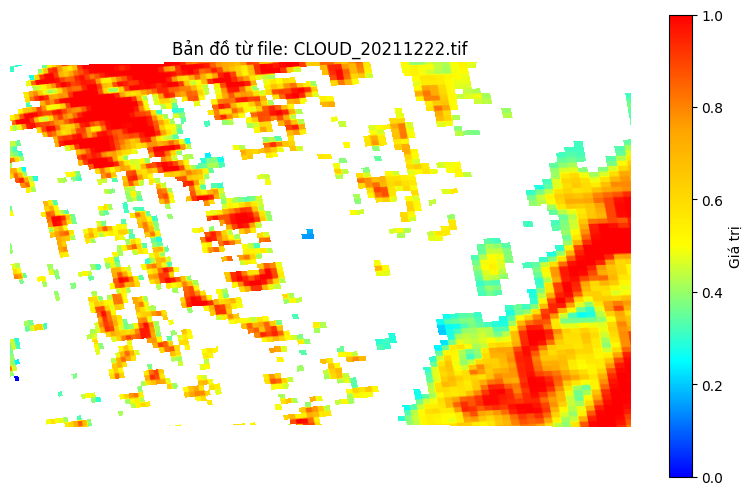

In [8]:
folder_path = 'Feature_Maps/CLOUD'
tif_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.tif')]

count = 1
for file_path in tif_files:
    if count == 1:
        plot_feature_map(file_path)
        count += 1
    else:
        break


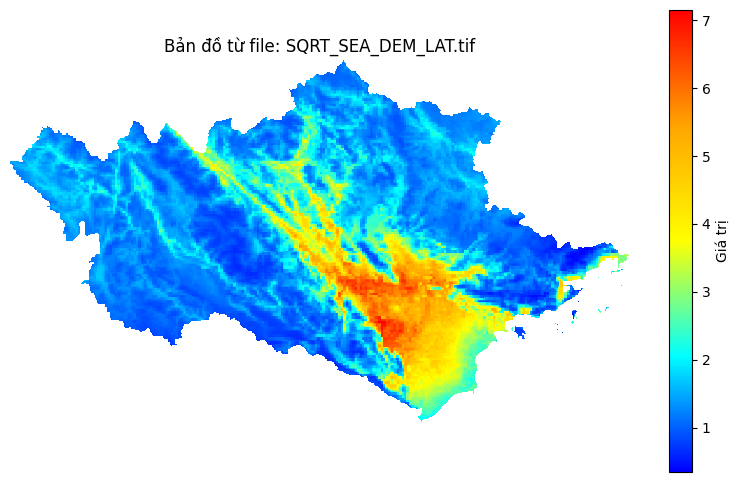

In [24]:
plot_feature_map('Feature_Maps/SQRT_SEA_DEM_LAT.tif')

## Test trích dữ liệu

In [10]:
dates = pd.read_csv('time.csv')
dates['time_yyyymmdd'] = dates['time'].str.replace('-', '')

# Lấy mảng time dạng yyyymmdd
time_array = dates['time_yyyymmdd'].values
time_array

array(['20211222', '20211223', '20211224', '20211225', '20211226',
       '20211227', '20211228', '20211229', '20211230', '20211231',
       '20220110', '20220111', '20220112', '20220113', '20220114',
       '20220115', '20220411', '20220412', '20220413', '20220414',
       '20220415', '20220501', '20220502', '20220503', '20220504',
       '20220505', '20220506', '20220507', '20220508', '20220509',
       '20220510', '20220515'], dtype=object)

In [11]:
# Danh sách feature theo ngày
FEATURES = ['WSPD', 'WDIR', 'TMP', 'TX', 'TN', 'TP', 'RH', 'PRES2M', 'UV', 'CLOUD', 'CO', 'HCHO', 'NO2', 'O3', 'SO2', 'NDVI']
DATES = time_array
BASE_FOLDER = 'Feature_Maps'
DEM_FILE = os.path.join(BASE_FOLDER, 'SQRT_SEA_DEM_LAT.tif')

def load_dem_array():
    """Load dữ liệu SQRT_SEA_DEM_LAT"""
    with rasterio.open(DEM_FILE) as src:
        return src.read(1), src.nodata


def get_lat_lon_grid(sample_tif_path):
    """Lấy lưới lat/lon ứng với từng pixel"""
    with rasterio.open(sample_tif_path) as src:
        height, width = src.height, src.width
        transform = src.transform

        lats = np.empty((height, width))
        lons = np.empty((height, width))
        for row in range(height):
            for col in range(width):
                lon, lat = rasterio.transform.xy(transform, row, col)
                lats[row, col] = lat
                lons[row, col] = lon

        return lats, lons
    
def load_feature_array(feature, date):
    """Load dữ liệu từ một file .tif của feature tại một ngày"""
    path = os.path.join(BASE_FOLDER, feature, f"{feature}_{date}.tif")
    with rasterio.open(path) as src:
        return src.read(1), src.nodata

In [12]:
def process_all_pixels():
    """Tạo DataFrame chứa dữ liệu cho toàn bộ pixel"""
    # Load DEM một lần
    dem_data, dem_nodata = load_dem_array()

    # Lấy toạ độ từ 1 ảnh mẫu
    sample_path = os.path.join(BASE_FOLDER, 'TX', f'TX_{DATES[0]}.tif')
    lats, lons = get_lat_lon_grid(sample_path)

    height, width = dem_data.shape
    all_rows = []

    for date in tqdm(DATES, desc="Processing dates"):
        # Load toàn bộ ảnh feature theo ngày
        feature_arrays = {}
        for feature in FEATURES:
            try:
                arr, nodata = load_feature_array(feature, date)
                feature_arrays[feature] = (arr, nodata)
            except Exception as e:
                print(f"Lỗi đọc {feature}_{date}: {e}")
                feature_arrays[feature] = (np.full((height, width), np.nan), None)

        date_str = datetime.strptime(date, "%Y%m%d").strftime("%Y-%m-%d")

        # Duyệt qua từng pixel
        for row in range(height):
            for col in range(width):
                dem_val = dem_data[row, col]
                if dem_val == dem_nodata:
                    continue  # Bỏ qua pixel không hợp lệ

                lat = lats[row, col]
                lon = lons[row, col]

                record = {
                    'time': date_str,
                    'lat': lat,
                    'lon': lon,
                    'SQRT_SEA_DEM_LAT': dem_val
                }

                for feature in FEATURES:
                    arr, nodata = feature_arrays[feature]
                    val = arr[row, col]
                    if nodata is not None and val == nodata:
                        val = np.nan
                    record[feature] = val

                all_rows.append(record)

    return pd.DataFrame(all_rows)

In [13]:
# df = process_all_pixels()
# df.head()


In [14]:
# df.to_csv('FEATURE_MAPS_data.csv', index=False)

In [18]:
df = pd.read_csv('FEATURE_MAPS_data.csv')
df

,time,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M,UV,CLOUD,CO,HCHO,NO2,O3,SO2,NDVI
0,2021-12-22,23.385,105.315,1.303528,1.067403,181.709120,11.351994,16.995990,7.657999,0.0,79.23125,86456.016,-0.531933,0.641521,0.032827,NaN,NaN,0.111337,NaN,0.726986
1,2021-12-22,23.385,105.325,1.303528,1.067403,181.709120,11.351994,16.995990,7.657999,0.0,79.23125,86456.016,-0.531933,0.641521,0.032827,NaN,NaN,0.111337,NaN,0.732047
2,2021-12-22,23.375,105.305,1.303528,1.039327,170.930370,11.339993,16.619990,7.889994,0.0,79.75625,86814.810,-0.484275,0.661521,0.032767,NaN,NaN,0.111295,NaN,0.759786
3,2021-12-22,23.375,105.315,1.303528,1.039327,170.930370,11.339993,16.619990,7.889994,0.0,79.75625,86814.810,-0.497945,0.662636,0.032762,NaN,NaN,0.111268,NaN,0.771341
4,2021-12-22,23.375,105.325,1.303528,1.039327,170.930370,11.339993,16.619990,7.889994,0.0,79.75625,86814.810,-0.485830,0.670163,0.032756,NaN,NaN,0.111243,NaN,0.736172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3238203,2022-05-15,19.955,106.065,2.034285,4.198421,1.842651,23.325003,26.050013,20.249994,16.0,91.30000,100747.270,0.529297,1.000000,NaN,NaN,NaN,0.127846,NaN,0.011072
3238204,2022-05-15,19.955,106.075,2.034285,4.198421,1.842651,23.325003,26.050013,20.249994,16.0,91.30000,100747.270,0.529297,1.000000,NaN,NaN,NaN,0.127846,NaN,0.009556
3238205,2022-05-15,19.955,106.085,2.140603,4.198421,1.842651,23.325003,26.050013,20.249994,16.0,91.30000,100747.270,0.529297,1.000000,NaN,NaN,NaN,0.127846,NaN,0.010367
3238206,2022-05-15,19.945,106.065,2.527502,4.198421,1.842651,23.325003,26.050013,20.249994,16.0,91.30000,100747.270,0.243087,1.000000,NaN,NaN,NaN,0.127596,NaN,0.009074


In [21]:
lat_lon_to_dem = (
    df.dropna(subset=["SQRT_SEA_DEM_LAT"])  # chỉ giữ dòng có SQRT_SEA_DEM_LAT
      .drop_duplicates(subset=["lat", "lon"])  # loại bỏ trùng (lat, lon)
      .set_index(["lat", "lon"])["SQRT_SEA_DEM_LAT"]
      .to_dict()
)

def fill_dem(row):
    if pd.isna(row["SQRT_SEA_DEM_LAT"]):
        return lat_lon_to_dem.get((row["lat"], row["lon"]), None)
    return row["SQRT_SEA_DEM_LAT"]

# Áp dụng hàm để điền giá trị thiếu
df["SQRT_SEA_DEM_LAT"] = df.apply(fill_dem, axis=1)
df

,time,lat,lon,SQRT_SEA_DEM_LAT,WSPD,WDIR,TMP,TX,TN,TP,RH,PRES2M,UV,CLOUD,CO,HCHO,NO2,O3,SO2,NDVI
0,2021-12-22,23.385,105.315,1.303528,1.067403,181.709120,11.351994,16.995990,7.657999,0.0,79.23125,86456.016,-0.531933,0.641521,0.032827,NaN,NaN,0.111337,NaN,0.726986
1,2021-12-22,23.385,105.325,1.303528,1.067403,181.709120,11.351994,16.995990,7.657999,0.0,79.23125,86456.016,-0.531933,0.641521,0.032827,NaN,NaN,0.111337,NaN,0.732047
2,2021-12-22,23.375,105.305,1.303528,1.039327,170.930370,11.339993,16.619990,7.889994,0.0,79.75625,86814.810,-0.484275,0.661521,0.032767,NaN,NaN,0.111295,NaN,0.759786
3,2021-12-22,23.375,105.315,1.303528,1.039327,170.930370,11.339993,16.619990,7.889994,0.0,79.75625,86814.810,-0.497945,0.662636,0.032762,NaN,NaN,0.111268,NaN,0.771341
4,2021-12-22,23.375,105.325,1.303528,1.039327,170.930370,11.339993,16.619990,7.889994,0.0,79.75625,86814.810,-0.485830,0.670163,0.032756,NaN,NaN,0.111243,NaN,0.736172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3238203,2022-05-15,19.955,106.065,2.034285,4.198421,1.842651,23.325003,26.050013,20.249994,16.0,91.30000,100747.270,0.529297,1.000000,NaN,NaN,NaN,0.127846,NaN,0.011072
3238204,2022-05-15,19.955,106.075,2.034285,4.198421,1.842651,23.325003,26.050013,20.249994,16.0,91.30000,100747.270,0.529297,1.000000,NaN,NaN,NaN,0.127846,NaN,0.009556
3238205,2022-05-15,19.955,106.085,2.140603,4.198421,1.842651,23.325003,26.050013,20.249994,16.0,91.30000,100747.270,0.529297,1.000000,NaN,NaN,NaN,0.127846,NaN,0.010367
3238206,2022-05-15,19.945,106.065,2.527502,4.198421,1.842651,23.325003,26.050013,20.249994,16.0,91.30000,100747.270,0.243087,1.000000,NaN,NaN,NaN,0.127596,NaN,0.009074


In [23]:
missing_rows = df[df['SQRT_SEA_DEM_LAT'].isna()]
print(missing_rows)


               time     lat      lon  SQRT_SEA_DEM_LAT      WSPD        WDIR  \
1700     2021-12-22  23.025  104.835               NaN  0.442869  171.069410   
1701     2021-12-22  23.025  104.845               NaN  0.442869  171.069410   
1794     2021-12-22  23.015  104.835               NaN  0.442869  171.069410   
1795     2021-12-22  23.015  104.845               NaN  0.442869  171.069410   
1889     2021-12-22  23.005  104.835               NaN  0.442869  171.069410   
...             ...     ...      ...               ...       ...         ...   
3237849  2022-05-15  20.125  107.685               NaN  9.081114   37.528076   
3237850  2022-05-15  20.125  107.695               NaN  9.081114   37.528076   
3237851  2022-05-15  20.125  107.705               NaN  9.081114   37.528076   
3237852  2022-05-15  20.125  107.715               NaN  9.081114   37.528076   
3237853  2022-05-15  20.125  107.725               NaN  9.081114   37.528076   

               TMP         TX         T

## AQI

Custom a cmap for discrete colors

In [16]:
# Các màu tương ứng từng mức AQI
aqi_colors = ['#00e400', '#ffff00', '#ff7e00', '#ff0000', '#8f3f97', '#7e0023']
aqi_bounds = [0, 50, 100, 150, 200, 300, 500]  # các mức phân chia

api_cmap = ListedColormap(aqi_colors)
norm = BoundaryNorm(aqi_bounds, api_cmap.N)